In [57]:
# utility
import sys
sys.path.append("..")

import utility

# imports
import numpy as np

# modelling
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Tree Visualization
import matplotlib.pyplot as plt

In [58]:
start_time = utility.time.time()

stop_thread = False

# global parameters
max_cpu_usage = 0
max_memory_usage = 0

def collect_cpu_mem_usage():
    global max_cpu_usage, max_memory_usage

    while not stop_thread:
        # Get current CPU and memory usage
        cpu_usage = utility.psutil.cpu_percent()
        memory_usage = utility.psutil.virtual_memory().percent

        # Initialize variables if not yet assigned
        if max_cpu_usage is None:
            max_cpu_usage = cpu_usage
        if max_memory_usage is None:
            max_memory_usage = memory_usage

        # Update maximum values if needed
        max_cpu_usage = max(max_cpu_usage, cpu_usage)
        max_memory_usage = max(max_memory_usage, memory_usage)

        # Sleep for a short interval (adjust as needed)
        utility.time.sleep(1)

# Start the function in a separate thread
thread = utility.threading.Thread(target=collect_cpu_mem_usage)
thread.start()

In [59]:
data, labels, _ = utility.load_data()

Dataset split: 70000 train rows
Dataset split: 70000 test rows


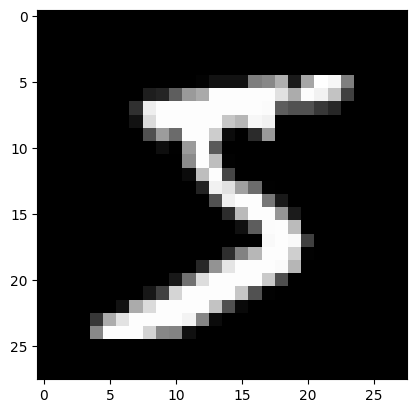

In [60]:
print(f"Dataset split: {len(data)} train rows")
print(f"Dataset split: {len(labels)} test rows")

point = data[0].reshape(28, 28)

plt.imshow(point, cmap='gray')
plt.show()

In [61]:
train_data, train_labels, test_data, test_labels, test_true_labels, anom_data = utility.preprocess_data(data, labels, False)

In [62]:
print(train_data.shape)
print(test_data.shape)
print(anom_data.shape)

(56000, 784)
(10004, 784)
(4, 784)


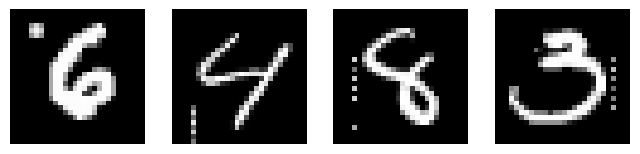

In [63]:
num_images = len(anom_data)
rows = 1
cols = num_images
fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
    
for i in range(num_images):
    axes[i].imshow(anom_data[i].reshape(28, 28), cmap='gray')
    axes[i].axis('off')
    
plt.show()

In [64]:
# parameters
contamination = 0.0004
max_features = 100
n_estimators = 512
random_state = 42

In [65]:
# Create a pipeline with PCA and Isolation Forest
model = IsolationForest(contamination=contamination, max_features=max_features, n_estimators=n_estimators, random_state=random_state, bootstrap=True)
# Train the model using the pipeline
model.fit(train_data)

IsolationForest(bootstrap=True, contamination=0.0004, max_features=100,
                n_estimators=512, random_state=42)

In [66]:
# Get anomaly scores for training and test data
scores_train = model.decision_function(train_data)
scores_test = model.decision_function(test_data)

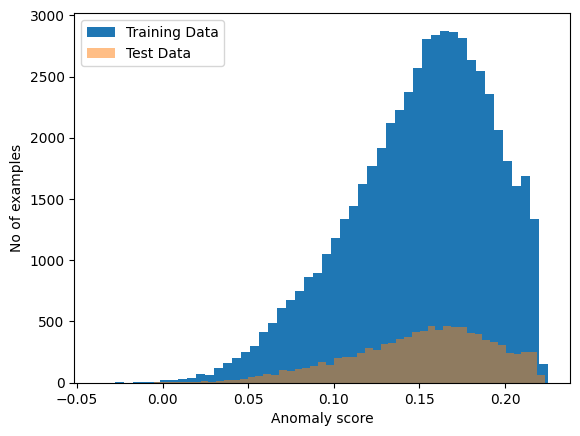

In [67]:
# Plot histograms of anomaly scores for training and test data
plt.hist(scores_train, bins=50, label='Training Data')
plt.hist(scores_test, bins=50, alpha=0.5, label='Test Data')
plt.xlabel("Anomaly score")
plt.ylabel("No of examples")
plt.legend()
plt.show()

In [68]:
# anomaly scores
anomaly_scores = model.decision_function(test_data)

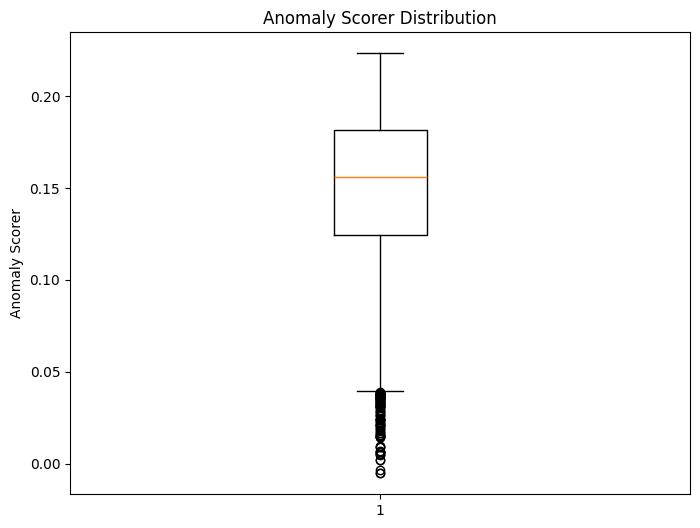

In [69]:
q1, q3, iqr, minimum, maximum = utility.boxplot_plot("Anomaly Scorer", anomaly_scores)

In [70]:
utility.print_boxplot(q1, q3, iqr, minimum, maximum)

Q1:  0.125
Q3:  0.181
IQR:  0.057
Minimum:  0.039
Maximum:  0.223


0.10922467479089867


C:\Users\zippe\AppData\Local\Temp\ipykernel_18124\1436118371.py:11: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(range(len(anomaly_scores)), anomaly_scores, c=['blue' if e > threshold else 'red' for e in anomaly_scores], cmap='coolwarm', marker='o', edgecolors='k')


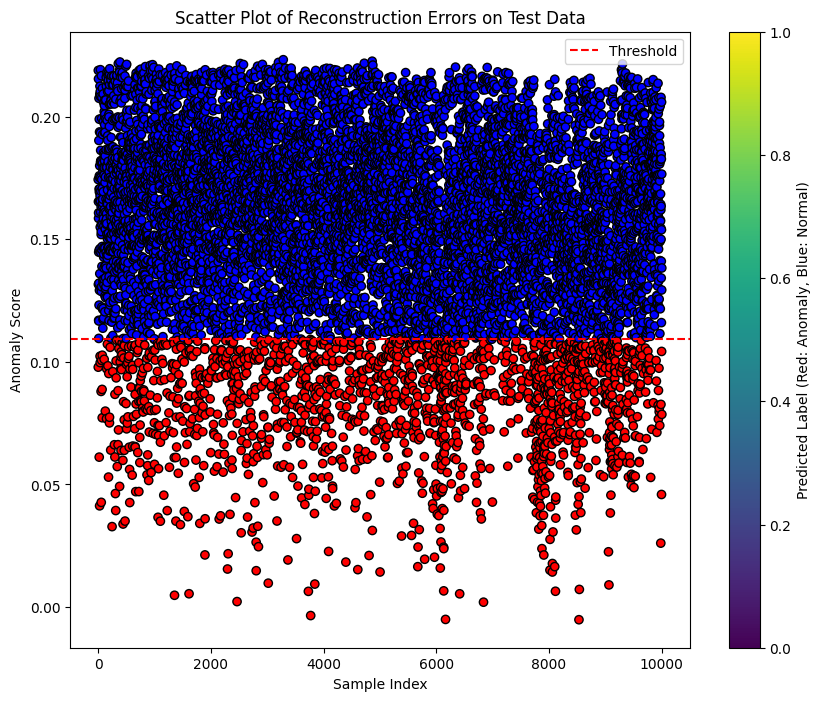

In [71]:
# Set a threshold for classifying anomalies
# threshold = 0.0 # Adjust this threshold as needed
threshold = np.mean(anomaly_scores) - np.std(anomaly_scores)
print(threshold)

# Create a binary array indicating anomalies
anomaly_indicator = np.where(anomaly_scores > threshold, 1, 0)

# Scatter plot with anomalies and normal instances based on anomaly prediction and threshold
plt.figure(figsize=(10, 8))
scatter = plt.scatter(range(len(anomaly_scores)), anomaly_scores, c=['blue' if e > threshold else 'red' for e in anomaly_scores], cmap='coolwarm', marker='o', edgecolors='k')
plt.axhline(y=threshold, color='red', linestyle='--', label='Threshold')
plt.title('Scatter Plot of Reconstruction Errors on Test Data')
plt.xlabel('Sample Index')
plt.ylabel('Anomaly Score')
plt.legend()
plt.colorbar(scatter, label='Predicted Label (Red: Anomaly, Blue: Normal)')
plt.show()

In [72]:
# Predict anomalies based on the custom threshold
preds = (anomaly_scores > threshold).astype(int)

# Convert labels from -1/1 to True/False
preds = preds == 1

In [73]:
a, p, r, f1, report, cm = utility.get_metrics(preds, test_true_labels)

In [74]:
utility.print_stats(a, p, r, f1, report, cm)

Accuracy = 0.8320671731307477
Precision = 0.9996396829209705
Recall = 0.8323
F1 = 0.9083269671504965
Report
               precision    recall  f1-score   support

     anomaly       0.00      0.25      0.00         4
      normal       1.00      0.83      0.91     10000

    accuracy                           0.83     10004
   macro avg       0.50      0.54      0.45     10004
weighted avg       1.00      0.83      0.91     10004

Confusion Matrix
[[   1    3]
 [1677 8323]]


True Negatives: 1
False Positives: 3
False Negatives: 1677
True Positives: 8323


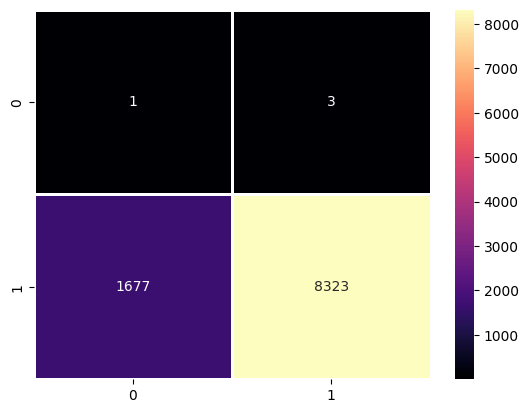

In [75]:
utility.create_heatmap(cm)

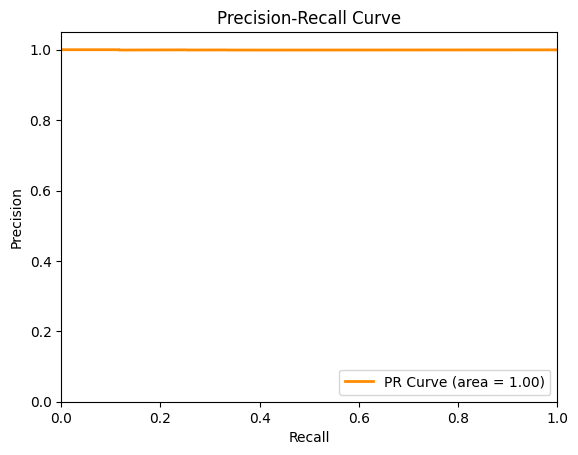

In [76]:
utility.pr_auc_plot(anomaly_scores, test_true_labels, True)

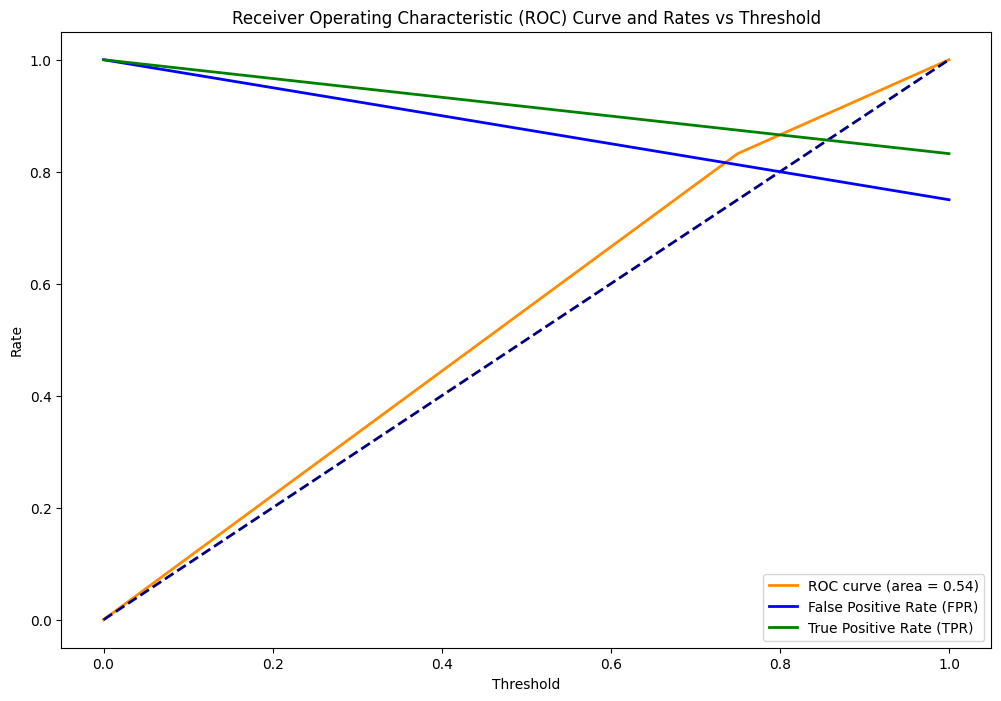

In [77]:
utility.roc_plot(preds, test_true_labels)

In [78]:
# Get anomaly scores for training and test data
scores_train = model.decision_function(train_data)
scores_test = model.decision_function(test_data)
scores_anom = model.decision_function(anom_data)

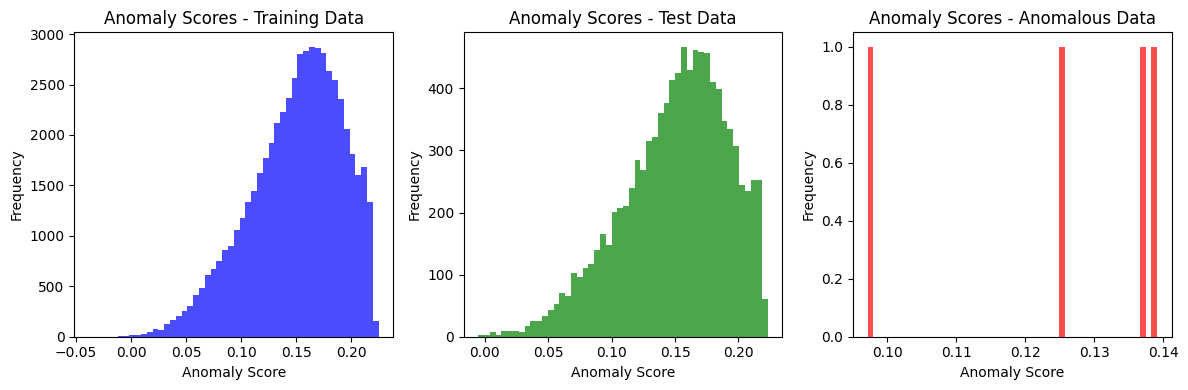

In [79]:
# Plotting histograms
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.hist(scores_train, bins=50, color='blue', alpha=0.7)
plt.title('Anomaly Scores - Training Data')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.hist(scores_test, bins=50, color='green', alpha=0.7)
plt.title('Anomaly Scores - Test Data')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
plt.hist(scores_anom, bins=50, color='red', alpha=0.7)
plt.title('Anomaly Scores - Anomalous Data')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [80]:
anomaly_indexes = utility.write_to_json(preds)

Anomaly indexes saved to .\anomalies.json


1678


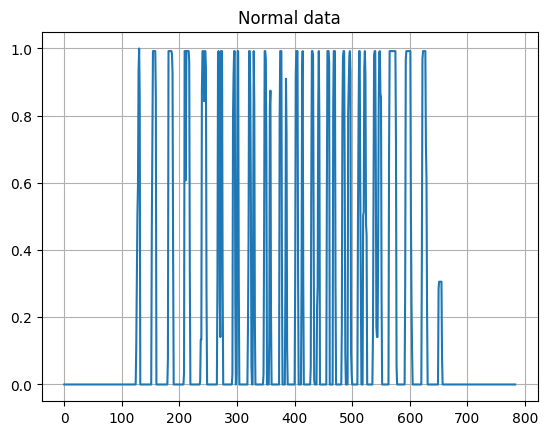

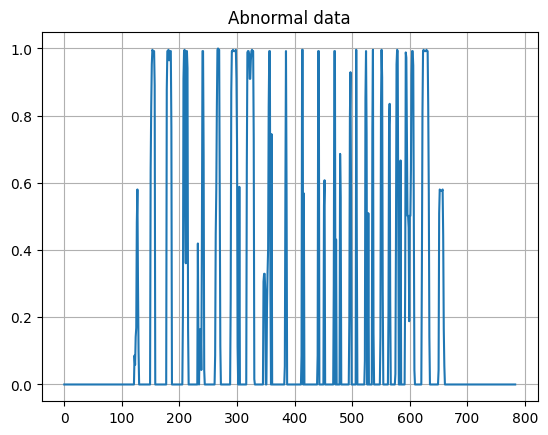

In [81]:
print(len(anomaly_indexes))

utility.plot_normalized_pixel_data(train_data, anom_data)

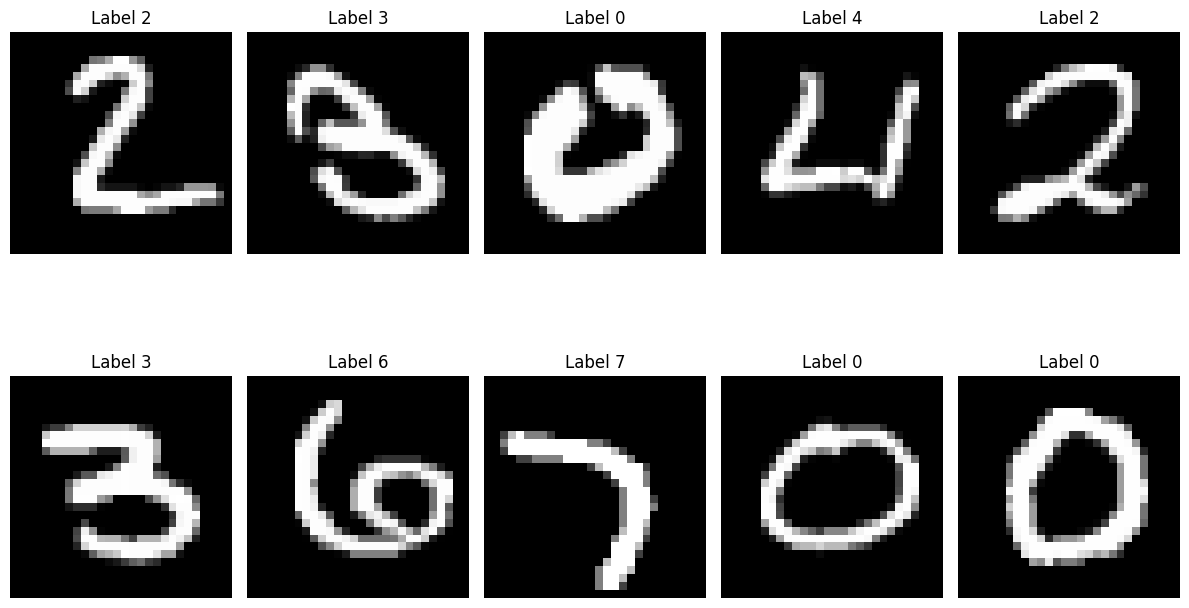

In [82]:
utility.plot_anomaly_imgs(anomaly_indexes, test_data, test_labels)

In [83]:
stop_thread = True

thread.join()
print(f"CPU Usage: {max_cpu_usage}%")
print(f"Memory Usage: {max_memory_usage}%")

CPU Usage: 11.3%
Memory Usage: 36.7%


In [84]:
end_time = utility.time.time()
total_time = end_time - start_time
print(f"Total execution time: {total_time} seconds")

Total execution time: 69.29507899284363 seconds
